## Discover topics from Enron Emails: A demo of how NTM works 
1. [Introduction](#Introduction)
2. [Preprocessing](#Preprocessing)
   1. [Create Bag-of-Words and Vocabulary](#Create-Bag-of-Words-and-Vocabulary)
   2. [TF-IDF Term Frequency Inverse Document Frequency](#TF-IDF-Term-Frequency-Inverse-Document-Frequency)
3. [Create Training Validation and Test Datasets](#Create-Training-Validation-and-Test-Datasets)
   1. [Store Data on S3](#Store-Data-on-S3)
   2. [Model Training](#Model-Training)
   3. [Set Hyperparameters](#Set-Hyperparameters)
4. [Model Hosting and Inference](#Model-Hosting-and-Inference)
  1. [Inference with CSV](#Inference-with-CSV)
  2. [Creating Word Cloud from Trained Model](#Creating-Word-Cloud-from-Trained-Model)

## Introduction 

In this notebook, we will look at discovering topics from enron emails. Neural Topic Model (NTM) from Amazon SageMaker uses neural networks to learn word embeddings or topics. The word embeddings are derived by minimizing loss when building stochastic representation of input documents/emails.

First, we build bag of words representation of each email, with each column representing a word and each row representing an email. The values in the matrix are number of times each word is repeated in a given email. We then scale the counts by multiplying them with TF-IDF factor (Term Frequency-Inverse Document Frequency). This factor ensures that words that are specific to a given email and are not repeated frequently across all emails are given higher weight, relative to the words that commonly occur across all emails (for ex: the, so, as, because etc). 

The prepared bag of words representation of emails is then fed into a neural network whose architecture is defined by the hyperparameters listed below. The network optimizes across several epochs by minimizing loss in building stochastic representation of emails (topic embeddings) and in reconstructing original emails from topic embeddings.

The dataset for this notebook is downloaded from [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/bag+of+words). It primarily contains list of words (vocabulary) used across all emails and a lookup table detailing number of occurrences of a word in a given email (EmailID WordID Count)

In [1]:
# **Acknowledgements, Copyright Information, and Availability**
# You may use this material free of charge for any educational purpose, 
# provided attribution is given in any lectures or publications that make use of this material.
#
# Source: https://archive.ics.uci.edu/ml/datasets/bag+of+words
# Source: SageMaker AWS Labs
    
import pandas as pd
import numpy as np

from sklearn.preprocessing import normalize
from scipy.sparse import csr_matrix
import os
from sagemaker import get_execution_role
import boto3
from sagemaker.amazon.amazon_estimator import get_image_uri
import sagemaker
from sagemaker.session import s3_input
from sagemaker.predictor import csv_serializer, json_deserializer
import warnings
warnings.simplefilter(action='ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

## Preprocessing 

First, let's run user defined functions used to conduct common operations

In [2]:
run bowemails.py

### Create Bag-of-Words and Vocabulary
We will only take 10% of emails to have a manageable dataset

In [3]:
ip_fn = 'data/docword.enron.txt.gz'
percent_emails = .10 # get only a x% of emails to avoid memory errors
vocab_ip_fn = 'data/vocab.enron.txt'
vocab_op_fn = 'data/vocab.txt'

#Get bag-of-words from input of enron emails
# We will filter emails to reduce data size
# Create vocabulary based on the subset of emails that will be sent to training
pvt_emails = prepare_bow_vocab(ip_fn, percent_emails, vocab_ip_fn, vocab_op_fn)

In [4]:
pvt_emails.head()

word_ID,1,3,4,8,9,15,16,19,20,21,...,28090,28091,28092,28093,28095,28096,28097,28098,28100,28101
email_ID,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
pvt_emails.shape

(3986, 17524)

### TF-IDF Term Frequency Inverse Document Frequency
We assume that the words that help surface topics are those that are not repeated across all emails but are common within an email.

In [6]:
tfidf_emails = TF_IDF(pvt_emails)

In [7]:
# convert pivoted dataframe to compressed sparse row matrix
# compressed sparse row matrix contains row pointer, column index and values
sparse_emails = csr_matrix(pvt_emails, dtype=np.float32)
print(sparse_emails[:16].toarray())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [13]:
type(sparse_emails)

scipy.sparse.csr.csr_matrix

## Create Training Validation and Test Datasets

In [8]:
n_train = int(0.8 * sparse_emails.shape[0])

# split train and test
train_vectors = sparse_emails[:n_train, :] 
test_vectors = sparse_emails[n_train:, :] 

# further split test set into validation set and test set
n_test = test_vectors.shape[0]
val_vectors = test_vectors[:n_test//2, :]
test_vectors = test_vectors[n_test//2:, :]

In [9]:
print(train_vectors.shape, test_vectors.shape, val_vectors.shape)

(3188, 17524) (399, 17524) (399, 17524)


### Store Data on S3

The NTM algorithm, as well as other first-party SageMaker algorithms, accepts data in RecordIO Protobuf format. The SageMaker Python API provides helper functions for easily converting your data into this format.

In [10]:
role = get_execution_role()
# provide your bucket name here
#bucket = '<bucket-name>'
bucket = 'ai-in-aws'
prefix = 'enronemails'

train_prefix = os.path.join(prefix, 'train')
val_prefix = os.path.join(prefix, 'val')
output_prefix = os.path.join(prefix, 'output')
aux_prefix = os.path.join(prefix, 'aux')

s3_train_data = os.path.join('s3://', bucket, train_prefix)
s3_val_data = os.path.join('s3://', bucket, val_prefix)
s3_aux_data = os.path.join('s3://', bucket, aux_prefix)
output_path = os.path.join('s3://', bucket, output_prefix)

print('Training Location', s3_train_data)
print('Validation set Location', s3_val_data)
print('Trained model will be saved at', output_path)
print('Auxiliary will be saved at', s3_aux_data)

Training Location s3://ai-in-aws/enronemails/train
Validation set Location s3://ai-in-aws/enronemails/val
Trained model will be saved at s3://ai-in-aws/enronemails/output
Auxiliary will be saved at s3://ai-in-aws/enronemails/aux


Partition the training data for parallel processing

In [11]:
# Convert compressed sparse row matrix to recordio-wrapped-protobuf format
# RecordIO is used to efficiently load large datasets (data can be read continuously and stored in a compressed format) 

split_convert_upload(train_vectors, bucket=bucket, prefix=train_prefix, fname_template='data_part{}.pbr', n_parts=3)
split_convert_upload(val_vectors, bucket=bucket, prefix=val_prefix, fname_template='val_part{}.pbr', n_parts=1)

### Model Training

SageMaker uses Amazon Elastic Container Registry (ECR) docker container to host the NTM training image. The ECR containers are currently available for SageMaker NTM training in different regions

Boto3 is the Amazon Web Services (AWS) Software Development Kit (SDK) for Python, which allows Python developers to write software that makes use of services like Amazon S3 and Amazon EC2

SageMaker SDK - A library for training and deploying machine learning models on Amazon SageMaker - aws/sagemaker-python-sdk.

In [12]:
container = get_image_uri(boto3.Session().region_name, 'ntm')

In [13]:
sess = sagemaker.Session()
ntm = sagemaker.estimator.Estimator(container,
                                   role,
                                   train_instance_count=2,
                                   train_instance_type='ml.c4.xlarge',
                                   output_path=output_path,
                                   sagemaker_session=sess)

##### Set Hyperparameters

__feature_dim__ - it should be set to vocabulary size <br>
__num_topics__ - topics to extract <br>
__mini_batch_size__ - this is the batch_size for each worker instance. <br>
__epochs__ - the maximal number of epochs to train for. <br>
__num_patience_epochs__ and tolerance control the early shopping behavior. Improvements smaller than the tolerance are not considered as improvement <br>
__optimizer and learning_rate__ - Adadelta optimizer and learning rate is not required <br>

In [22]:
s3_train_data

's3://ai-in-aws/enronemails/train'

In [14]:
num_topics = 3
vocab_size = 17524 # from shape from pivoted emails dataframe
ntm.set_hyperparameters(num_topics=num_topics, 
                        feature_dim=vocab_size, 
                        mini_batch_size=30, 
                        epochs=150, 
                        num_patience_epochs=5, 
                        tolerance=.001)

In [15]:
# Upload vocabulary file to auxiliary folder on S3 bucket -- this is used to identify words associated with latent topics
aux_path = s3_aux_data + "/"

!aws s3 cp $vocab_op_fn $aux_path

upload: data/vocab.txt to s3://ai-in-aws/enronemails/aux/vocab.txt


In [16]:
s3_train = s3_input(s3_train_data, distribution='ShardedByS3Key', content_type='application/x-recordio-protobuf')
s3_val = s3_input(s3_val_data, distribution='FullyReplicated',
                  content_type='application/x-recordio-protobuf')
s3_aux = s3_input(s3_aux_data, distribution='FullyReplicated', content_type='text/plain')

In [17]:
ntm.fit({'train': s3_train, 'validation': s3_val, 'auxiliary': s3_aux})

INFO:sagemaker:Creating training-job with name: ntm-2019-04-09-17-24-19-713


2019-04-09 17:24:19 Starting - Starting the training job...
2019-04-09 17:24:23 Starting - Launching requested ML instances......
2019-04-09 17:25:29 Starting - Preparing the instances for training.........
2019-04-09 17:27:13 Downloading - Downloading input data
2019-04-09 17:27:13 Training - Training image download completed. Training in progress..
Docker entrypoint called with argument(s): train
[04/09/2019 17:27:15 INFO 139701951670080] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'num_patience_epochs': u'3', u'clip_gradient': u'Inf', u'encoder_layers': u'auto', u'optimizer': u'adadelta', u'_kvstore': u'auto_gpu', u'rescale_gradient': u'1.0', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'learning_rate': u'0.01', u'_data_format': u'record', u'sub_sample': u'1.0', u'epochs': u'50', u'weight_decay': u'0.0', u'_num_kv_servers': u'auto', u'encoder_layers_activation': u'sigmoid', u'mini_batch_size': u'256', u'tole

[04/09/2019 17:27:32 WARNING 139701951670080] 1421 out of 17524 in vocabulary do not have embeddings! Default vector used for unknown embedding!
[04/09/2019 17:27:32 INFO 139701951670080] Vocab embedding shape
[04/09/2019 17:27:32 INFO 139701951670080] Number of GPUs being used: 0
[04/09/2019 17:27:32 INFO 139701951670080] Create Store: dist_async
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Max Records Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Reset Count": {"count": 1, "max": 0, "sum": 0.0, "min": 0}}, "EndTime": 1554830852.534066, "Dimensions": {"Host": "algo-2", "Meta": "init_train_data_iter", "Oper

[04/09/2019 17:27:36 INFO 139701951670080] # Finished training epoch 2 on 1062 examples from 36 batches, each of size 30.
[04/09/2019 17:27:36 INFO 139701951670080] Metrics for Training:
[04/09/2019 17:27:36 INFO 139701951670080] Loss (name: value) total: 8.44441777688
[04/09/2019 17:27:36 INFO 139701951670080] Loss (name: value) kld: 0.237974265107
[04/09/2019 17:27:36 INFO 139701951670080] Loss (name: value) recons: 8.20644351112
[04/09/2019 17:27:36 INFO 139701951670080] Loss (name: value) logppx: 8.44441777688
[04/09/2019 17:27:36 INFO 139701951670080] #quality_metric: host=algo-2, epoch=2, train total_loss <loss>=8.44441777688
[2019-04-09 17:27:36.831] [tensorio] [info] data_pipeline_stats={"name": "/opt/ml/input/data/validation", "epoch": 1, "duration": 2307, "num_examples": 14}
[04/09/2019 17:27:37 INFO 139701951670080] Finished scoring on 390 examples from 13 batches, each of size 30.
[04/09/2019 17:27:37 INFO 139701951670080] Metrics for Inference:
[04/09/2019 17:27:37 INFO 13

[04/09/2019 17:27:47 INFO 139701951670080] # Finished training epoch 7 on 1062 examples from 36 batches, each of size 30.
[04/09/2019 17:27:47 INFO 139701951670080] Metrics for Training:
[04/09/2019 17:27:47 INFO 139701951670080] Loss (name: value) total: 8.13558810905
[04/09/2019 17:27:47 INFO 139701951670080] Loss (name: value) kld: 0.151424572644
[04/09/2019 17:27:47 INFO 139701951670080] Loss (name: value) recons: 7.98416351742
[04/09/2019 17:27:47 INFO 139701951670080] Loss (name: value) logppx: 8.13558810905
[04/09/2019 17:27:47 INFO 139701951670080] #quality_metric: host=algo-2, epoch=7, train total_loss <loss>=8.13558810905
[2019-04-09 17:27:47.640] [tensorio] [info] data_pipeline_stats={"name": "/opt/ml/input/data/validation", "epoch": 6, "duration": 2093, "num_examples": 14}
[04/09/2019 17:27:47 INFO 139701951670080] Finished scoring on 390 examples from 13 batches, each of size 30.
[04/09/2019 17:27:47 INFO 139701951670080] Metrics for Inference:
[04/09/2019 17:27:47 INFO 13

[04/09/2019 17:27:58 INFO 139701951670080] Finished scoring on 390 examples from 13 batches, each of size 30.
[04/09/2019 17:27:58 INFO 139701951670080] Metrics for Inference:
[04/09/2019 17:27:58 INFO 139701951670080] Loss (name: value) total: 8.65798648932
[04/09/2019 17:27:58 INFO 139701951670080] Loss (name: value) kld: 0.162592315674
[04/09/2019 17:27:58 INFO 139701951670080] Loss (name: value) recons: 8.49539427146
[04/09/2019 17:27:58 INFO 139701951670080] Loss (name: value) logppx: 8.65798648932
[04/09/2019 17:27:58 INFO 139701951670080] #validation_score (12): 8.65798648932
[04/09/2019 17:27:58 INFO 139701951670080] patience losses:[8.7008792975010021, 8.6768955328525639, 8.7091611030774239, 8.660844030135717, 8.6749284010667065] min patience loss:8.66084403014 current loss:8.65798648932 absolute loss difference:0.0028575408153
[04/09/2019 17:27:58 INFO 139701951670080] Timing: train: 2.12s, val: 0.23s, epoch: 2.36s
[04/09/2019 17:27:58 INFO 139701951670080] #progress_metric: 

[04/09/2019 17:28:06 INFO 139661896189760] # Finished training epoch 8 on 2126 examples from 71 batches, each of size 30.
[04/09/2019 17:28:06 INFO 139661896189760] Metrics for Training:
[04/09/2019 17:28:06 INFO 139661896189760] Loss (name: value) total: 8.28090968602
[04/09/2019 17:28:06 INFO 139661896189760] Loss (name: value) kld: 0.150343493509
[04/09/2019 17:28:06 INFO 139661896189760] Loss (name: value) recons: 8.13056624865
[04/09/2019 17:28:06 INFO 139661896189760] Loss (name: value) logppx: 8.28090968602
[04/09/2019 17:28:06 INFO 139661896189760] #quality_metric: host=algo-1, epoch=8, train total_loss <loss>=8.28090968602
[2019-04-09 17:28:06.624] [tensorio] [info] data_pipeline_stats={"name": "/opt/ml/input/data/validation", "epoch": 7, "duration": 4326, "num_examples": 14}
[04/09/2019 17:28:06 INFO 139661896189760] Finished scoring on 390 examples from 13 batches, each of size 30.
[04/09/2019 17:28:06 INFO 139661896189760] Metrics for Inference:
[04/09/2019 17:28:06 INFO 13

[04/09/2019 17:28:15 INFO 139661896189760] # Finished training epoch 10 on 2126 examples from 71 batches, each of size 30.
[04/09/2019 17:28:15 INFO 139661896189760] Metrics for Training:
[04/09/2019 17:28:15 INFO 139661896189760] Loss (name: value) total: 8.2641465308
[04/09/2019 17:28:15 INFO 139661896189760] Loss (name: value) kld: 0.146514151802
[04/09/2019 17:28:15 INFO 139661896189760] Loss (name: value) recons: 8.1176324119
[04/09/2019 17:28:15 INFO 139661896189760] Loss (name: value) logppx: 8.2641465308
[04/09/2019 17:28:15 INFO 139661896189760] #quality_metric: host=algo-1, epoch=10, train total_loss <loss>=8.2641465308
[2019-04-09 17:28:15.306] [tensorio] [info] data_pipeline_stats={"name": "/opt/ml/input/data/validation", "epoch": 9, "duration": 4298, "num_examples": 14}
[04/09/2019 17:28:15 INFO 139661896189760] Finished scoring on 390 examples from 13 batches, each of size 30.
[04/09/2019 17:28:15 INFO 139661896189760] Metrics for Inference:
[04/09/2019 17:28:15 INFO 1396

[04/09/2019 17:28:31 INFO 139661896189760] # Finished training epoch 14 on 2126 examples from 71 batches, each of size 30.
[04/09/2019 17:28:31 INFO 139661896189760] Metrics for Training:
[04/09/2019 17:28:31 INFO 139661896189760] Loss (name: value) total: 8.20477106515
[04/09/2019 17:28:31 INFO 139661896189760] Loss (name: value) kld: 0.158357581062
[04/09/2019 17:28:31 INFO 139661896189760] Loss (name: value) recons: 8.04641348969
[04/09/2019 17:28:31 INFO 139661896189760] Loss (name: value) logppx: 8.20477106515
[04/09/2019 17:28:31 INFO 139661896189760] #quality_metric: host=algo-1, epoch=14, train total_loss <loss>=8.20477106515
[2019-04-09 17:28:31.689] [tensorio] [info] data_pipeline_stats={"name": "/opt/ml/input/data/validation", "epoch": 13, "duration": 4295, "num_examples": 14}
[04/09/2019 17:28:31 INFO 139661896189760] Finished scoring on 390 examples from 13 batches, each of size 30.
[04/09/2019 17:28:31 INFO 139661896189760] Metrics for Inference:
[04/09/2019 17:28:31 INFO

[04/09/2019 17:28:36 INFO 139661896189760] Finished scoring on 390 examples from 13 batches, each of size 30.
[04/09/2019 17:28:36 INFO 139661896189760] Metrics for Inference:
[04/09/2019 17:28:36 INFO 139661896189760] Loss (name: value) total: 8.58119182098
[04/09/2019 17:28:36 INFO 139661896189760] Loss (name: value) kld: 0.138855264126
[04/09/2019 17:28:36 INFO 139661896189760] Loss (name: value) recons: 8.44233644926
[04/09/2019 17:28:36 INFO 139661896189760] Loss (name: value) logppx: 8.58119182098
[04/09/2019 17:28:36 INFO 139661896189760] #validation_score (15): 8.58119182098
[04/09/2019 17:28:36 INFO 139661896189760] patience losses:[8.642828330015524, 8.6249487852438911, 8.6099223992763427, 8.6162535056089737, 8.5886044233273235] min patience loss:8.58860442333 current loss:8.58119182098 absolute loss difference:0.00741260235126
[04/09/2019 17:28:36 INFO 139661896189760] Timing: train: 4.18s, val: 0.27s, epoch: 4.45s
[04/09/2019 17:28:36 INFO 139661896189760] #progress_metric:

[04/09/2019 17:28:48 INFO 139701951670080] Finished scoring on 390 examples from 13 batches, each of size 30.
[04/09/2019 17:28:48 INFO 139701951670080] Metrics for Inference:
[04/09/2019 17:28:48 INFO 139701951670080] Loss (name: value) total: 8.61953797952
[04/09/2019 17:28:48 INFO 139701951670080] Loss (name: value) kld: 0.150058490802
[04/09/2019 17:28:48 INFO 139701951670080] Loss (name: value) recons: 8.46947940924
[04/09/2019 17:28:48 INFO 139701951670080] Loss (name: value) logppx: 8.61953797952
[04/09/2019 17:28:48 INFO 139701951670080] #validation_score (35): 8.61953797952
[04/09/2019 17:28:48 INFO 139701951670080] patience losses:[8.5946973360501797, 8.6333042633839145, 8.5676865797776447, 8.6382405990209339, 8.5604534833859169] min patience loss:8.56045348339 current loss:8.61953797952 absolute loss difference:0.0590844961313
[04/09/2019 17:28:48 INFO 139701951670080] Bad epoch: loss has not improved (enough). Bad count:1
[04/09/2019 17:28:48 INFO 139701951670080] Timing: t

[04/09/2019 17:28:58 INFO 139661896189760] # Finished training epoch 20 on 2126 examples from 71 batches, each of size 30.
[04/09/2019 17:28:58 INFO 139661896189760] Metrics for Training:
[04/09/2019 17:28:58 INFO 139661896189760] Loss (name: value) total: 8.1110986629
[04/09/2019 17:28:58 INFO 139661896189760] Loss (name: value) kld: 0.17596267098
[04/09/2019 17:28:58 INFO 139661896189760] Loss (name: value) recons: 7.93513598375
[04/09/2019 17:28:58 INFO 139661896189760] Loss (name: value) logppx: 8.1110986629
[04/09/2019 17:28:58 INFO 139661896189760] #quality_metric: host=algo-1, epoch=20, train total_loss <loss>=8.1110986629
[2019-04-09 17:28:58.057] [tensorio] [info] data_pipeline_stats={"name": "/opt/ml/input/data/validation", "epoch": 19, "duration": 4328, "num_examples": 14}
[04/09/2019 17:28:58 INFO 139661896189760] Finished scoring on 390 examples from 13 batches, each of size 30.
[04/09/2019 17:28:58 INFO 139661896189760] Metrics for Inference:
[04/09/2019 17:28:58 INFO 139

[04/09/2019 17:29:11 INFO 139661896189760] # Finished training epoch 23 on 2126 examples from 71 batches, each of size 30.
[04/09/2019 17:29:11 INFO 139661896189760] Metrics for Training:
[04/09/2019 17:29:11 INFO 139661896189760] Loss (name: value) total: 8.07730666326
[04/09/2019 17:29:11 INFO 139661896189760] Loss (name: value) kld: 0.177319417761
[04/09/2019 17:29:11 INFO 139661896189760] Loss (name: value) recons: 7.89998724852
[04/09/2019 17:29:11 INFO 139661896189760] Loss (name: value) logppx: 8.07730666326
[04/09/2019 17:29:11 INFO 139661896189760] #quality_metric: host=algo-1, epoch=23, train total_loss <loss>=8.07730666326
[2019-04-09 17:29:11.120] [tensorio] [info] data_pipeline_stats={"name": "/opt/ml/input/data/validation", "epoch": 22, "duration": 4305, "num_examples": 14}
[04/09/2019 17:29:11 INFO 139661896189760] Finished scoring on 390 examples from 13 batches, each of size 30.
[04/09/2019 17:29:11 INFO 139661896189760] Metrics for Inference:
[04/09/2019 17:29:11 INFO

[04/09/2019 17:29:18 INFO 139701951670080] # Finished training epoch 49 on 1062 examples from 36 batches, each of size 30.
[04/09/2019 17:29:18 INFO 139701951670080] Metrics for Training:
[04/09/2019 17:29:18 INFO 139701951670080] Loss (name: value) total: 7.698505225
[04/09/2019 17:29:18 INFO 139701951670080] Loss (name: value) kld: 0.169906467641
[04/09/2019 17:29:18 INFO 139701951670080] Loss (name: value) recons: 7.52859875008
[04/09/2019 17:29:18 INFO 139701951670080] Loss (name: value) logppx: 7.698505225
[04/09/2019 17:29:18 INFO 139701951670080] #quality_metric: host=algo-2, epoch=49, train total_loss <loss>=7.698505225
[2019-04-09 17:29:18.293] [tensorio] [info] data_pipeline_stats={"name": "/opt/ml/input/data/validation", "epoch": 48, "duration": 2353, "num_examples": 14}
[04/09/2019 17:29:18 INFO 139701951670080] Finished scoring on 390 examples from 13 batches, each of size 30.
[04/09/2019 17:29:18 INFO 139701951670080] Metrics for Inference:
[04/09/2019 17:29:18 INFO 13970

[04/09/2019 17:29:28 INFO 139701951670080] # Finished training epoch 54 on 1062 examples from 36 batches, each of size 30.
[04/09/2019 17:29:28 INFO 139701951670080] Metrics for Training:
[04/09/2019 17:29:28 INFO 139701951670080] Loss (name: value) total: 7.65536160646
[04/09/2019 17:29:28 INFO 139701951670080] Loss (name: value) kld: 0.169969867998
[04/09/2019 17:29:28 INFO 139701951670080] Loss (name: value) recons: 7.48539165214
[04/09/2019 17:29:28 INFO 139701951670080] Loss (name: value) logppx: 7.65536160646
[04/09/2019 17:29:28 INFO 139701951670080] #quality_metric: host=algo-2, epoch=54, train total_loss <loss>=7.65536160646
[2019-04-09 17:29:28.960] [tensorio] [info] data_pipeline_stats={"name": "/opt/ml/input/data/validation", "epoch": 53, "duration": 2001, "num_examples": 14}
[04/09/2019 17:29:29 INFO 139701951670080] Finished scoring on 390 examples from 13 batches, each of size 30.
[04/09/2019 17:29:29 INFO 139701951670080] Metrics for Inference:
[04/09/2019 17:29:29 INFO

[04/09/2019 17:29:36 INFO 139661896189760] # Finished training epoch 29 on 2126 examples from 71 batches, each of size 30.
[04/09/2019 17:29:36 INFO 139661896189760] Metrics for Training:
[04/09/2019 17:29:36 INFO 139661896189760] Loss (name: value) total: 7.99112879077
[04/09/2019 17:29:36 INFO 139661896189760] Loss (name: value) kld: 0.187911583224
[04/09/2019 17:29:36 INFO 139661896189760] Loss (name: value) recons: 7.80321720464
[04/09/2019 17:29:36 INFO 139661896189760] Loss (name: value) logppx: 7.99112879077
[04/09/2019 17:29:36 INFO 139661896189760] #quality_metric: host=algo-1, epoch=29, train total_loss <loss>=7.99112879077
[2019-04-09 17:29:36.644] [tensorio] [info] data_pipeline_stats={"name": "/opt/ml/input/data/validation", "epoch": 28, "duration": 3592, "num_examples": 14}
[04/09/2019 17:29:36 INFO 139661896189760] Finished scoring on 390 examples from 13 batches, each of size 30.
[04/09/2019 17:29:36 INFO 139661896189760] Metrics for Inference:
[04/09/2019 17:29:36 INFO

[04/09/2019 17:29:50 INFO 139661896189760] # Finished training epoch 33 on 2126 examples from 71 batches, each of size 30.
[04/09/2019 17:29:50 INFO 139661896189760] Metrics for Training:
[04/09/2019 17:29:50 INFO 139661896189760] Loss (name: value) total: 7.86878202197
[04/09/2019 17:29:50 INFO 139661896189760] Loss (name: value) kld: 0.200186223939
[04/09/2019 17:29:50 INFO 139661896189760] Loss (name: value) recons: 7.6685957931
[04/09/2019 17:29:50 INFO 139661896189760] Loss (name: value) logppx: 7.86878202197
[04/09/2019 17:29:50 INFO 139661896189760] #quality_metric: host=algo-1, epoch=33, train total_loss <loss>=7.86878202197
[2019-04-09 17:29:50.682] [tensorio] [info] data_pipeline_stats={"name": "/opt/ml/input/data/validation", "epoch": 32, "duration": 3373, "num_examples": 14}
[04/09/2019 17:29:50 INFO 139661896189760] Finished scoring on 390 examples from 13 batches, each of size 30.
[04/09/2019 17:29:50 INFO 139661896189760] Metrics for Inference:
[04/09/2019 17:29:50 INFO 

[04/09/2019 17:30:05 INFO 139661896189760] # Finished training epoch 37 on 2126 examples from 71 batches, each of size 30.
[04/09/2019 17:30:05 INFO 139661896189760] Metrics for Training:
[04/09/2019 17:30:05 INFO 139661896189760] Loss (name: value) total: 7.82466785986
[04/09/2019 17:30:05 INFO 139661896189760] Loss (name: value) kld: 0.205948635222
[04/09/2019 17:30:05 INFO 139661896189760] Loss (name: value) recons: 7.618719289
[04/09/2019 17:30:05 INFO 139661896189760] Loss (name: value) logppx: 7.82466785986
[04/09/2019 17:30:05 INFO 139661896189760] #quality_metric: host=algo-1, epoch=37, train total_loss <loss>=7.82466785986
[2019-04-09 17:30:05.180] [tensorio] [info] data_pipeline_stats={"name": "/opt/ml/input/data/validation", "epoch": 36, "duration": 3676, "num_examples": 14}
[04/09/2019 17:30:05 INFO 139661896189760] Finished scoring on 390 examples from 13 batches, each of size 30.
[04/09/2019 17:30:05 INFO 139661896189760] Metrics for Inference:
[04/09/2019 17:30:05 INFO 1

[04/09/2019 17:30:19 INFO 139661896189760] # Finished training epoch 41 on 2126 examples from 71 batches, each of size 30.
[04/09/2019 17:30:19 INFO 139661896189760] Metrics for Training:
[04/09/2019 17:30:19 INFO 139661896189760] Loss (name: value) total: 7.79924741933
[04/09/2019 17:30:19 INFO 139661896189760] Loss (name: value) kld: 0.212242428126
[04/09/2019 17:30:19 INFO 139661896189760] Loss (name: value) recons: 7.58700500632
[04/09/2019 17:30:19 INFO 139661896189760] Loss (name: value) logppx: 7.79924741933
[04/09/2019 17:30:19 INFO 139661896189760] #quality_metric: host=algo-1, epoch=41, train total_loss <loss>=7.79924741933
[2019-04-09 17:30:19.908] [tensorio] [info] data_pipeline_stats={"name": "/opt/ml/input/data/validation", "epoch": 40, "duration": 3720, "num_examples": 14}
[04/09/2019 17:30:20 INFO 139661896189760] Finished scoring on 390 examples from 13 batches, each of size 30.
[04/09/2019 17:30:20 INFO 139661896189760] Metrics for Inference:
[04/09/2019 17:30:20 INFO

[04/09/2019 17:30:34 INFO 139661896189760] # Finished training epoch 45 on 2126 examples from 71 batches, each of size 30.
[04/09/2019 17:30:34 INFO 139661896189760] Metrics for Training:
[04/09/2019 17:30:34 INFO 139661896189760] Loss (name: value) total: 7.77295310867
[04/09/2019 17:30:34 INFO 139661896189760] Loss (name: value) kld: 0.211221278217
[04/09/2019 17:30:34 INFO 139661896189760] Loss (name: value) recons: 7.56173183817
[04/09/2019 17:30:34 INFO 139661896189760] Loss (name: value) logppx: 7.77295310867
[04/09/2019 17:30:34 INFO 139661896189760] #quality_metric: host=algo-1, epoch=45, train total_loss <loss>=7.77295310867
[2019-04-09 17:30:34.738] [tensorio] [info] data_pipeline_stats={"name": "/opt/ml/input/data/validation", "epoch": 44, "duration": 3700, "num_examples": 14}
[04/09/2019 17:30:34 INFO 139661896189760] Finished scoring on 390 examples from 13 batches, each of size 30.
[04/09/2019 17:30:34 INFO 139661896189760] Metrics for Inference:
[04/09/2019 17:30:34 INFO


2019-04-09 17:30:55 Completed - Training job completed
Billable seconds: 467


In [18]:
print('Training job name: {}'.format(ntm.latest_training_job.job_name))

Training job name: ntm-2019-04-09-17-24-19-713


## Model Hosting and Inference

In [19]:
ntm_predictor = ntm.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: ntm-2019-04-09-18-52-54-810
INFO:sagemaker:Creating endpoint with name ntm-2019-04-09-17-24-19-713


----------------------------------------------------------------------------!

In [20]:
print('Endpoint name: {}'.format(ntm_predictor.endpoint))

Endpoint name: ntm-2019-04-09-17-24-19-713


### Inference with CSV

In [21]:
ntm_predictor.content_type = 'text/csv'
ntm_predictor.serializer = csv_serializer
ntm_predictor.deserializer = json_deserializer

In [22]:
#Convert test vectors from compressed sparse matrix to dense matrix
test_data = np.array(test_vectors.todense())

In [32]:
results = ntm_predictor.predict(test_data[1:5])
print(results)

{'predictions': [{'topic_weights': [0.0780238435, 0.5128391385, 0.4091370702]}, {'topic_weights': [0.0647637397, 0.5575146079, 0.3777216673]}, {'topic_weights': [0.0770179257, 0.2474122494, 0.6755698323]}, {'topic_weights': [0.0907187015, 0.6687077284, 0.240573585]}]}


In [33]:
predictions = np.array([prediction['topic_weights'] for prediction in results['predictions']])
print(predictions)

[[0.07802384 0.51283914 0.40913707]
 [0.06476374 0.55751461 0.37772167]
 [0.07701793 0.24741225 0.67556983]
 [0.0907187  0.66870773 0.24057359]]


Text(0.5,0,'Topic ID')

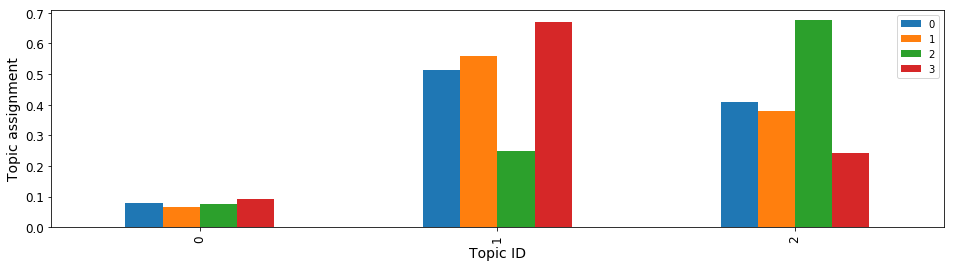

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

fs=12
df=pd.DataFrame(predictions.T)
df.plot(kind='bar', figsize=(16,4), fontsize=fs)
plt.ylabel('Topic assignment', fontsize=fs+2)
plt.xlabel('Topic ID', fontsize=fs+2)

### Creating Word Cloud from Trained Model

In [35]:
!pip install mxnet
!pip install wordcloud
import wordcloud as wc
import mxnet as mx

    100% |████████████████████████████████| 28.4MB 1.8MB/s eta 0:00:01
    100% |████████████████████████████████| 13.8MB 7.0MB/s eta 0:00:01
  Found existing installation: numpy 1.15.4
    Uninstalling numpy-1.15.4:
      Successfully uninstalled numpy-1.15.4
You are using pip version 10.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [36]:
#Determine the location of the model output
current_job_name = ntm.latest_training_job.job_name

model_path = os.path.join(output_prefix, current_job_name, 'output/model.tar.gz')
model_path

'enronemails/output/ntm-2019-04-09-17-24-19-713/output/model.tar.gz'

In [37]:
#Download the model
boto3.resource('s3').Bucket(bucket).download_file(model_path, 'downloaded_model.tar.gz')

In [38]:
#unzip the model output
!tar -xzvf 'downloaded_model.tar.gz'

model_algo-2
model_algo-1


In [39]:
!unzip -o model_algo-1

Archive:  model_algo-1
 extracting: meta.json               
 extracting: symbol.json             
 extracting: params                  


In [40]:
model = mx.ndarray.load('params')
W = model['arg:projection_weight']

In [41]:
# Retrieving word distributions for each of the latent topics 
W


[[-1.6004856 -2.60862   -1.9256244]
 [-1.5195873 -2.801778  -2.5669572]
 [-1.5795462 -2.8432672 -2.3337717]
 ...
 [-1.5052562 -2.8511627 -2.35806  ]
 [-1.5185319 -2.8104594 -2.4379675]
 [-1.5643051 -2.8513684 -2.3724968]]
<NDArray 17524x3 @cpu(0)>

In [47]:
# Create vocabulary list
vocab_list = pd.read_table(vocab_op_fn, header=None)
vocab_list = vocab_list[0].tolist()
len(vocab_list)

17524

In [49]:
#Iterate through the vocabulary list to create dictionary of key values for each of the words in vocabulary
word_to_id = {}

for i, v in enumerate(vocab_list):
    #print("Index and Value", i, v)
    word_to_id[v] = i
    
limit = 24
n_col = 4
counter = 0

In [50]:
word_to_id

{'aaa': 0,
 'aactive': 1,
 'aadvantage': 2,
 'aaron': 3,
 'aarp': 4,
 'aba': 5,
 'abacus': 6,
 'abandon': 7,
 'abandoned': 8,
 'abandoning': 9,
 'abated': 10,
 'abb': 11,
 'abbott': 12,
 'abbreviated': 13,
 'abbreviation': 14,
 'abc': 15,
 'abel': 16,
 'aberration': 17,
 'abide': 18,
 'abilene': 19,
 'abilities': 20,
 'ability': 21,
 'able': 22,
 'abn': 23,
 'aboard': 24,
 'abolish': 25,
 'abolishing': 26,
 'abound': 27,
 'abovemarket': 28,
 'abraham': 29,
 'abreast': 30,
 'abroad': 31,
 'abrogate': 32,
 'abrupt': 33,
 'abruptly': 34,
 'absence': 35,
 'absences': 36,
 'absent': 37,
 'absentee': 38,
 'absolute': 39,
 'absolutely': 40,
 'absorb': 41,
 'absorbed': 42,
 'absorbing': 43,
 'abstract': 44,
 'abt': 45,
 'abundance': 46,
 'abundant': 47,
 'abuse': 48,
 'abuses': 49,
 'academia': 50,
 'academic': 51,
 'academy': 52,
 'acc': 53,
 'accelerate': 54,
 'accelerated': 55,
 'accelerates': 56,
 'accelerating': 57,
 'acceleration': 58,
 'accent': 59,
 'accenture': 60,
 'accept': 61,
 'ac

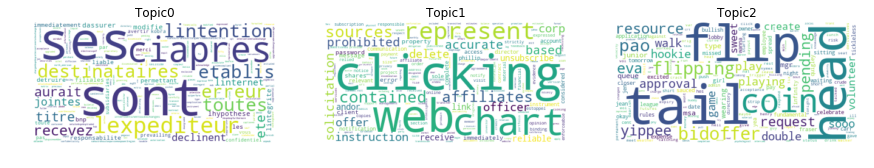

In [51]:
# For each of the topics synthesized, get the word distribution
plt.figure(figsize=(20,16))
for ind in range(num_topics):

    if counter >= limit:
        break

    title_str = 'Topic{}'.format(ind)

    #Use softmax function to assign probability for each of the word associated with the topic
    # The sum of all the probabilities of words associated with each topic should add up to 1
    pvals = mx.nd.softmax(mx.nd.array(W[:, ind])).asnumpy()
    #print("Printing pvals: ", len(pvals))
    
    word_freq = dict()
    for k in word_to_id.keys():
        i = word_to_id[k]
        word_freq[k] =pvals[i]

    wordcloud = wc.WordCloud(background_color='white').fit_words(word_freq)

    plt.subplot(limit // n_col, n_col, counter+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title_str)
    #plt.close()

    counter +=1